In [12]:
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import numpy as onp
from jax import jacfwd, grad, jit
from jaxlie import SE2, SO2, manifold
import meshcat
from meshcat import transformations as tfm
from meshcat import geometry as geom
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def euler_step(x, f, dt, *args):
    return x + f(x, *args) * dt

def rk4_step(x, f, dt, *args):
    # one step of runge-kutta integration
    k1 = dt * f(x, *args)
    k2 = dt * f(x + k1/2, *args)
    k3 = dt * f(x + k2/2, *args)
    k4 = dt * f(x + k3, *args)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

# Cart Pendulum Swingup

In this homework, we will be controlling a cart pendulum to perform a swingup using iLQR.


## Dynamics Model 
To start, first we want to establish the dynamics of the cart pendulum. You can use the E-L equations, but for this example, I will assume I already have this: 
$$
\begin{equation}
    \dot{x} = \frac{d}{dt} \begin{bmatrix} \theta \\ p \\ \dot{\theta} \\ \dot{p} \end{bmatrix} = 
    \begin{bmatrix}
        \dot{\theta} \\ 
        \dot{p} \\ 
        \frac{g}{l} \cdot \sin(\theta) + \frac{u}{l} \cos(\theta) - c_1 \dot{\theta} \\ 
        u - c_2 \dot{p}
    \end{bmatrix}
\end{equation}
$$
where the state $x = [\theta, p, \dot{\theta}, \dot{p}]^\top$ is the pole angle on the cart body, the cart position, and the angular and linear velocities respectively, $u\in\mathbb{R}^1$ is the cart acceleration, and $g, l, c_1, c_2$ are gravity, pole length, and damping constants respectively. 

In [13]:
_g = 9.81
_c1 = 0.02
_c2 = 0.02
_l = 1.0
def f(x, u):
    """
        Cart-Pole Dynamics
        input: x \in R^4, u \in R^1
        output: \dot{x} \in R^4
    """
    th, p, thdot, pdot = x
    return np.array([
                thdot, pdot,
                _g*np.sin(th)/_l+u[0]*np.cos(th)/_l-_c1*thdot,
                u[0]-_c2*pdot])

## Q1 10 pts: Swingup Objective Function 
Now we need to write down the objective function. Assuming that we do not need any state or control constraints (we will discuss how to include these later), we want an objective function where the running cost $\ell(x, u)$ has a minimum at the vertical pole position i.e., $\theta=0$ and when $p=0$. In addition, we want to ensure that velocities are minimized (no jerky movements), so we also want a term that penalizes too large $\dot{p}, \dot{\theta}$. Furthermore, since we have no constraints on the control input $u$, we want to penalize too large of a control input. 

An obvious choice would be the running cost $\Vert x \Vert^2 + \Vert u \Vert^2$, however, this does not fully capture that the pole can rotate mod $2 pi$ and be at the upright equilibrium. As a result, underneath the running cost proposed, $6 \pi$ would be considered a "poor" choice (though it is OK). Therefore, we want a function that is *cyclical* in nature that represents this behavior. A good candidate function can be shown to be $(\cos(\theta)-1)^2$
$$
\begin{equation}
\mathcal{J}(x, u) = \int_{t_0}^{t_f} \ell(x,u) dt.
\end{equation}
$$
where 
$$
    \ell(x, u) = c_1 (\cos(\theta) - 1)^2 + c_2 p^2 + c_3 \Vert \dot{q} \Vert^2 + \Vert u \Vert_R^2
$$
and $c_n, R$ are weights that penalize certain terms more than others. 
We will use $c_1 = 5, c_2 = 1.0, c_3=0.1, R=0.01$.
Note that we can also describe the pole rotation of the robot over SE(2) and define derivatives through in the Lie Algebra, but we will leave this as an extra credit final project. 

It is also often convenient to specify some terminal cost $m(x(t_f))$ though not always necessary. Here, let us choose $m(x) = 0.$ and assume that we have an integration step of $\Delta t = 0.1$. 


In [14]:
_R = np.diag(np.array([0.01]))
_Rinv = np.linalg.inv(_R)

def swingup_cost(x, u):
    c1 = 5.0
    c2 = 1.0
    c3 = 0.1
    R = 0.01
    q, qdot = np.split(x, 2)
    # return c1 * (np.cos(q[0]) - 1)**2 + c2 * q[1]**2 + c3 * np.sum(qdot ** 2) + R * np.linalg.norm(u) ** 2
    return c1 * (np.cos(q[0]) - 1)**2 + c2 * q[1]**2 + 0.1* qdot@qdot + 0.01*np.sum(u**2)

def terminal_cost(x):
    return 0.0

## Iterative Linear Quadratic Regulator 

Not all systems have the nice linear quadratic form which facilitates control solutions like LQR. 
In fact, many have constraints that are nonlinear and objective that are nonconvex. 
Specifically, the optimal control problem often looks more generally like 
\begin{align}
    &\min_\xi \mathcal{J}(\xi) = \int_{t_0}^{t_f} \ell(x, u) dt \\ 
    &\text{subject to } \dot{x} = f(x, u) \nonumber
\end{align}
Looking at the derivative of the Lagrangian $\mathcal{L}$ in the direction of $\zeta = (z, v)$ (we often use $\delta x, \delta u$, but it is easier to think of $z,v$ as variables) we can approximately \emph{linearlize} the nonlinear optimal control problem:
\begin{align}
    D \mathcal{L} \cdot \zeta = \int_{t_0}^{t_f} D \ell(\xi) \cdot \zeta + \lambda^\top \left( A z + B v - \dot{z}\right) dt
\end{align}
where $A = \frac{\partial f}{\partial x}\mid_{x(t), u(t)}, B=\frac{\partial f}{\partial u}\mid_{x(t), u(t)}$ are the result of linearizing $\dot{x} = f(x, u)$ about variations $z, v$ yielding 
\begin{equation}
    D \left( f(x, u) - \dot{x} \right) \cdot (z, v) = \frac{\partial f}{\partial x} z + \frac{\partial f}{\partial u} v - \dot{z}
\end{equation}
this is similar to taking a Taylor expansion. 
Since we are approximating the optimal control problem based the first-order derivative, our goal is to find the largest descent direction for $\zeta$ such that we don't stray too far from $\zeta$ being a valid approximation. 
What we do in this case is to add in to the above problem a term that penalizing too large of a step $\zeta$, but does not make the above linearization nonconvex. 
The simplest choice is to add a norm $\Vert \zeta \Vert^2$ that is convex (think of this as another LQR problem), making the linearization of $\mathcal{L}$ 
\begin{equation}
    D \mathcal{L} \cdot \zeta = \int_{t_0}^{t_f} D \ell(\xi) \cdot \zeta + \lambda^\top \left(Az + Bv - \dot{z} \right) + \Vert \zeta \Vert^2 dt
\end{equation}
where the optimal control problem becomes 
\begin{align}
    \min_\zeta \int_{t_0}^{t_f} D \ell(\xi) \cdot \zeta + \lambda^\top \left(Az + Bv - \dot{z} \right) + \Vert \zeta \Vert^2 dt
\end{align}
which we write over $\zeta$ instead of $\xi$ (we are looking at the \emph{largest} descent direction).
From this, we can see that the control Hamiltonian can be formulated as 
\begin{equation}
    \mathcal{H} = a^\top z + b^\top v + \frac{1}{2}\left( z^\top Q z + v^\top R v\right) + \lambda^\top\left(Az + Bv\right)
\end{equation}
where the term $\frac{1}{2}\left( z^\top Q z + v^\top R v\right)$ arises from the choice of norm $\Vert \zeta \Vert^2$, and
\begin{equation}
    (a(t)^\top, b(t)^\top) = D \ell(\xi)
\end{equation} 
are terms that come from the derivative of the running cost $\ell$. 
From the Hamiltonian, we can write out the optimality conditions about $\zeta = (z, v)$
\begin{align}
    \dot{z} &= \frac{\partial \mathcal{H}}{\partial \lambda}^\top = Az + Bu \\ 
    -\dot{\lambda} &= \frac{\partial \mathcal{H}}{\partial z}^\top = a + Qz + A^\top \lambda \\ 
    0 &= \frac{\partial \mathcal{H}}{\partial v}^\top = b + Rv + B^\top p
\end{align}
where $v = -R^{-1}\left(B^\top \lambda + b\right)$. As we did before with the LQR case, we seek to find a solution to $\lambda$ such that we can express the control decent direction $v$ in closed form as a function of $z$. 
Since the Hamiltonian above is not only quadratic, but affine (through the $a,b$ terms), a good choice is $\lambda = P(t)z(t) + r(t)$, where $P(t)$ is a matrix, and $r(t)$ is an affine vector (to account for affine terms). 
As we did before, let's take the time derivative of $\lambda$  and expand: 
\small{
\begin{align*}
    \lambda &= Pz + r \\ 
    \dot{\lambda} &= \dot{P}z + P \dot{z} + \dot{r} \\ 
    -a - Qz - A^\top \lambda &= \dot{P}z + PAz + PBv + \dot{r} \\
    -a -Qz - A^\top Pz - A^\top r &= \dot{P}z + PAz + PBv + \dot{r} \\ 
    -a -Qz -A^\top Pz -A^\top r &= \dot{P}z + PAz + PB\left(-R^{-1}B^\top\lambda -R^{-1}b\right) + \dot{r} \\ 
    -a -Qz -A^\top Pz -A^\top r &= \dot{P}z + PAz - PBR^{-1}B^\top\lambda - PBR^{-1}b + \dot{r} \\ 
    -a -Qz -A^\top Pz -A^\top r &= \dot{P}z + PAz - PBR^{-1}B^\top Pz -PBR^{-1}B^\top r - PBR^{-1}b + \dot{r} \\ 
    0 &= \left(\dot{P} + PA + A^\top P - RBR^{-1}B^\top P + Q\right)z + \left(\dot{r} + \left(A - BR^{-1}B^\top P\right)^\top r + a - PBR^{-1}b \right)
\end{align*}
}
which gives us two differential equations 
\begin{align}
    0 &= \dot{P} + PA + A^\top P - PBR^{-1}B^\top P + Q \\ 
    0 &= \dot{r} + \left(A - BR^{-1}B^\top P\right)^\top r + a - PBR^{-1}b
\end{align}
with terminal condition $P(t_f) = \mathbf{0}, r(t_f) = \mathbf{0}$,
and the resulting descent direction in the control is given by 
\begin{equation}
    v = -R^{-1}B^\top Pz - R^{-1}B^\top r - R^{-1}b
\end{equation}
where the state descent direction is taken care of through the two-point boundary value problem as 
\begin{equation}
\dot{z} = A(t) z = B(t) v, \text{ with IC } z(t_0) = 0.
\end{equation}
The controller is then updated as 
$u \gets u + \alpha v$ for a single iteration. 
Looping this back into an algorithm, we get the iterative LQR controller or iLQR!


## Q2 20 pts: Linearizations and Riccati Equations

Fill in the equations below for the linearization and the Riccati differential equations below.

In [15]:
def lin_dyn_eq(z, v, A, B):
    """
        input: z, v, A, B
        outdot: zdot = A@z + B@v
    """
    # add code here
    return A@z + B@v

def ricatti_P_diff_eq(P, A, B, Q, Rinv):
    """
        input: P, A, B, Q, Rinv
        output: \dot{P} = -(Q + A.T@P + P@A - PBRinvB.TP)
    """
    # add code here
    return -(Q + A.T @ P + P @ A - P @ B @ Rinv @ B.T @ P)

def ricatti_r_diff_eq(r, P, a, b, A, B, Rinv):
    """
        input: r, P, A, B, Q, Rinv
        output: \dot{r} = -( (A - BRinvB.TP).T @ r + a - PBRinvb )
    """
    # add code here
    return -((A - B @ Rinv @ B.T @ P).T @ r + a - P @ B @ Rinv @ b)


### helper functions for checking answers and for computing derivatives

In [16]:
## we will need to compute the derivative of the dynamics and running cost  along the trajectory
dfdx = jit(jacfwd(f, argnums=0))
dfdu = jit(jacfwd(f, argnums=1))
dldx = jit(jacfwd(swingup_cost, argnums=0))
dldu = jit(jacfwd(swingup_cost, argnums=1))
dmdx = jit(jacfwd(terminal_cost))

## and we will need specific Q,R terms in the linearized space for z an v

_Qz = np.eye(4)
_Rv = np.eye(1)
_Rvinv = np.linalg.inv(_Rv)

Check your answer below.

[[ -1.           0.         -10.73104084   0.        ]
 [  0.          -1.           0.          -1.        ]
 [-10.73104084   0.           0.03003329   0.99500417]
 [  0.          -1.           0.99500417   0.04      ]] [-9.73602835 -0.6         0.93100748  0.92100417]


In [17]:
z_test = np.ones(4)
v_test = np.ones(1)
x_test = np.array([0.1,0.3,0.4,0.5])
u_test = np.array([0.3])
_A_test = dfdx(x_test, u_test)
_B_test = dfdu(x_test, u_test)
_a_test = dldx(x_test, u_test)
_b_test = dldu(x_test, u_test)
_P_test = np.diag(np.ones_like(x_test))
_r_test = np.ones_like(x_test)
print(
    ricatti_P_diff_eq(_P_test, _A_test, _B_test, _Qz, _Rvinv),
    ricatti_r_diff_eq(_r_test, _P_test, _a_test, _b_test, _A_test, _B_test, _Rvinv)
)

[[ -1.          -0.         -10.73104084  -0.        ]
 [ -0.          -1.          -0.          -1.        ]
 [-10.73104084  -0.           0.03003329   0.99500417]
 [ -0.          -1.           0.99500417   0.04      ]] [-9.73602835 -0.6         0.93100748  0.92100417]


### more helper functions for simulation
to perform integration (both forward and backwards) for iLQR, study them for they are useful tools to know how to code up! 

In [18]:
## we will also define time and its discretization in the following manner
t0 = 0
tf = 2
dt = 0.1
N = int(tf/dt)

# functions to define the integration by one step \Delta t
@jit
def forward_step(x, u):
    """
        solves x[t+dt] = x[t] + dt * f(x[t], u[t])
    """
    return rk4_step(x, f, dt, u)

@jit
def forward_z_step(z, v, A, B):
    """
        solves z[t+dt] = x[t] + dt * (A[t]@z[t] + B[t]@v[t])
    """
    return rk4_step(z, lin_dyn_eq, dt, v, A, B)

@jit
def backward_P_step(P, a, b, A, B, Q, Rinv):
    """
        solves P[t-dt] = P[t] - dt * dotP(P, A, B, Q, Rinv)
    """
    return rk4_step(P, ricatti_P_diff_eq, -dt, A, B, Q, Rinv)

@jit
def backward_r_step(P, r, a, b, A, B, Q, Rinv):
    """
        solve r[t-dt] = r[t] - dt * dotr(r, P, A, B, Q, Rinv)
    """
    return rk4_step(r, ricatti_r_diff_eq, -dt, P, a, b, A, B, Rinv)

def solve_ricatti_eq(Pf, rf, a, b, A, B):
    _P    = Pf
    _r    = rf # this should be the same as state dimension
    P = []
    r = []
    for t in reversed(range(N)):
        _P = backward_P_step(_P, a[t], b[t], A[t], B[t], _Qz, _Rvinv)
        _r = backward_r_step(_P, _r, a[t], b[t], A[t], B[t], _Qz, _Rvinv)
        # helps with stability
        _P = (_P + _P.T) * 0.5
        P.append(_P.copy())
        r.append(_r.copy())
    ## flip the list backwards
    return (P[::-1], r[::-1])

def forward_sim(x0, U):
    """
        forward sim function:
            input: initial condition x0, control list U = [u0, u1, ..., uN-1]
            output:
                trajectory: X = [x0,x1, ..., xN-1],
                terminal state: x[N]
                cost linearization: a[t] = dldx[t], b[t] = dldu[t]
                dynamics linearization: A[t] = dfdx[t], B[t]=dfdu[t]
                note: linearization are along X, U
    """
    X = []
    a = []
    b = []
    A = []
    B = []
    _x = x0.copy()
    for t in range(N):
        X.append(_x.copy())
        a.append(dldx(_x, U[t]))
        b.append(dldu(_x, U[t]))
        A.append(dfdx(_x, U[t]))
        B.append(dfdu(_x, U[t]))
        _x = forward_step(_x, U[t])
    xf = _x
    return X, xf, a, b, A, B

## Q3 20 pts: Calculating the descent direction for x and u (z and v)

Below, plug in the equations above to solve for the descent direction. 

In [19]:
def calc_desc_dir(P, r, b, A, B):
    """
        Computes the descent trajectories z[t], v[t]
        Input (all list representing trajectorys):
                P[t], r[t], b[t], A[t], B[t]
        Output (a list representing trajectories):
                z[t], v[t]
    """
    z = []
    v = []
    _z = np.zeros_like(r[0])
    for _P, _r, _b, _A, _B in zip(P, r, b, A, B):

        # add code here
        _v = -_Rvinv @ _B.T @ _P @ _z - _Rvinv @ _B.T @ _r - _Rvinv @ _b
        _z = forward_z_step(_z, _v, _A, _B)

        z.append(_z.copy())
        v.append(_v.copy())
    return z, v

def update_control(U, v, alpha=0.1):
    """
        Update control U[t] along the descent direction v[t]
        Input: U[t], v[t], (default stepsize alpha=0.1)
        Output: updated U[t] along the the direction v[t] with step size alpha
    """
    for t, (ut, vt) in enumerate(zip(U,v)):
        U[t] = ut + alpha * vt # add code here
    return U

def calc_norm_zv(z, v):
    _out = 0.0
    for i, vt in enumerate(v):
        _out = _out + z[i] @ np.dot(_Qz, z[i]) + vt @ np.dot(_Rv, vt)
    return _out/len(v)

### Initial Conditions

In [20]:
U = [np.zeros((1,)) for _ in range(N)]
x0 = np.array([3.1, 0.0, 0., 0.])
Pf = np.diag(np.zeros_like(x0))
rf = np.zeros_like(x0)


## Q4 10 pts: Putting the pieces together

Using the initial conditions and the code above write an algorithm for updating the control solution for the iLQR problem. You know you did it correctly if the pendulum reaches the swing up state (0, +- 2 pi, +- 4 pi, etc..)

||v|| + ||z|| 0.007113925586982234


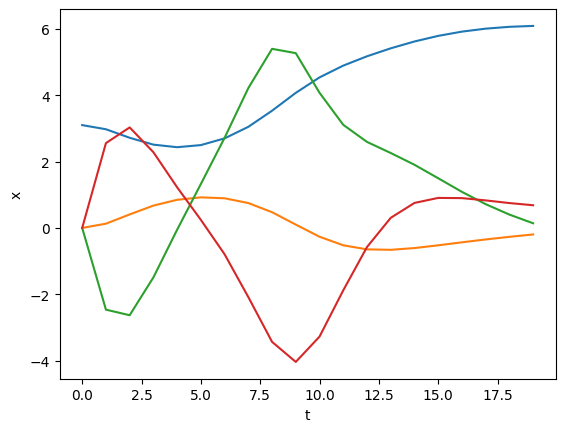

In [21]:
norm_v = np.inf
for kk in range(1_000):
    X, xf, a, b, A, B = forward_sim(x0.copy(), U)
    # add code here, use P, r, z, r, U variables for the trajectory lists

    # solve ricatti equations
    P, r = solve_ricatti_eq(Pf, rf, a, b, A, B)
    # calculate descent direction
    z, v = calc_desc_dir(P, r, b, A, B)
    # update controls
    U = update_control(U, v)
    # print(X)
    # print(xf)
    # print(P)
    # print(r)
    # break

    norm_v  = calc_norm_zv(z,v)
    if kk % 10 == 0:
        clear_output(wait=True)
        print('||v|| + ||z||',norm_v)
        plt.plot(np.stack(X))
        plt.xlabel('t')
        plt.ylabel('x')
        plt.pause(0.001)


### Animate the solution below

In [22]:
import meshcat
from meshcat import transformations as tfm
from meshcat import geometry as geom

In [23]:
viz = meshcat.Visualizer()
cart  = viz["cart"]
cart_geom = cart["geom"]
cart_geom.set_object(
    geom.Box([0.5,0.5,0.2]),
)
pivot = cart["pivot"]
pole = pivot["pole"]
pole_geom = pole["geom"]
pole_geom.set_transform(tfm.translation_matrix([0,0,0.5]))
pole_geom.set_object(
    geom.Box([0.1,0.1,1.0])
)

viz.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [24]:
for t in range(N):
    _x = X[t]
    q, qdot = np.split(_x, 2)
    cart.set_transform(
        tfm.translation_matrix([0,q[1],0])
    )
    pivot.set_transform(
        tfm.rotation_matrix(q[0],[1,0,0])
    )
    time.sleep(dt)

## Extra Credit 10 pts: LQR stabilizing controller 
write an LQR stabilizing controller for once the pendulum is in the upright position following the open-loop control `U[t]`, the system can stabilize using the LQR feedback controller `u = Klqr @ x` . Visualize the results below.